**IMPLEMENTATION OF THE LIE GROUP VARIATIONAL INTEGRATOR FOR RIGID BODY DYNAMICS** 
$\newline$
In this notebook I want to prototype an implementation of the Lie Group Variational Integrator.
The details of the derivations can be found in Lee, McClamroch, and Leok's 2005 Paper, 'A Lie Group Variational Integrator for the Attitude Dynamics of a Rigid Body with applications to the 3D Pendulum. 
The general gist, is to discretize the Lagrangian, and use Hamilton's principle to derive the discrete equations of motion that's computed on the manifold. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

The final result given by the paper in equation 33 for the discrete eom of a 3D pendulum is: 
\begin{equation}
    \Pi_{k+1} = F_k ^ T \Pi_k + \frac{h}{2} mg F_k ^ T ( \rho \times R_k ^ T e_3) + \frac{h}{2} mg \rho \times R_{k+1}^T e_3
\end{equation}

\begin{equation}
    h S(\Pi_k + \frac{h}{2} M_k) = F_k J_d - J_d F_k ^ T
\end{equation}

\begin{equation}
    R_{k+1} = R_k F_k
\end{equation}

The $S(.)$ mapping is a skew-symmetric mapping with the property $S(x)y = x \times y$. 

In section III.C of the paper, we are given a discretised algebraic form of the 2nd equation above:

\begin{equation}
h \Pi_k + \frac{h^2}{2} M_k = \frac{\sin ||f_k||}{||f_k||} J f_k + \frac{1-\cos||f_k||}{||f_k||^2}f_k \times J f_k
\end{equation}

This can be solved by Newton Iteration method. 

So ultimately the process would be: 
Given $R_0$, $\Pi_0$, we solve for $F_0$, then $R_1$ is updated, and the angular momentum $\Pi_1$ is updated by eq1. 



In [4]:
def S(x): 
    # S mapping
    # skew symmetric mapping with S(x)y = cross(x,y)
    return np.array([[0., -x[2], x[1]],
                     [x[2], 0., -x[0]],
                     [-x[1], x[0], 0.]])

def c1_c2_and_derivs(a):
    if a < 1e-8:
        # use Taylor expansions for small values. 
        c1 = 1 - a*a/6 + a**4/120
        c2 = 0.5 - a*a/24 + a**4/720
        dc1 = -a/3 + a**3/30
        dc2 = -1/12 + a*a/120
    else:
        c1 = np.sin(a)/a
        c2 = (1 - np.cos(a)) / (a*a)
        dc1 = (a*np.cos(a) - np.sin(a)) / (a*a)
        dc2 = (a*np.sin(a) - 2*(1 - np.cos(a))) / (a**3)
    return c1, c2, dc1, dc2    

Let's now implement a multivariate Newton Iteration method to solve (4) for $f_k$, which we can use with the Rodrigues' formula to find $F_k$.

\begin{equation}
G(f) := \frac{\sin ||f_k||}{||f_k||} J f_k + \frac{1-\cos||f_k||}{||f_k||^2}f_k \times J f_k - \left(h \Pi_k + \frac{h^2}{2} M_k \right) = 0
\end{equation}

\begin{equation}
    f_{n+1} = f_n - [ \nabla G(f_n) ]^{-1} G(f_n) 
\end{equation}

where $ \nabla G(f_n)$ is the Jacobian of $G(f_n)$.

The jacobian of $G(f)$ is given by: 

\begin{equation}

\nabla G(f) = c_1(a) J + c_1'(a) \frac{(Jf) f^\top}{a} + c_2 (a) \left( -S(Jf) + S(f)J \right) + c_2 ' (a) \frac{(f \times Jf) f^\top}{a}

\end{equation}

where $a = ||f||$.

In [5]:
def solving_for_f(J, Pi_k, M_k, h, tol = 1e-10, maxit = 50): 
    'Newton Iteration implementation to solve for f'
    
    b = h * Pi_k + ((h**2)/2) * M_k #constant vector
    f = np.linalg.solve(J,b) # setting initial conditions

    # iterating
    for i in range(maxit):
        a = np.linalg.norm(f)
        c1, c2, dc1, dc2 = c1_c2_and_derivs(a)
        Jf = J @ f
        cross = np.cross(f, Jf)

        # G(f)
        G = c1 * Jf + c2 * cross - b

        if np.linalg.norm(G) < tol:
            return f, True, i

        # Jacobian DG(f)
        f_transpose = np.transpose(f)
        S_terms = -S(Jf) + S(f) @ J
        DG = c1 * J + c2 * S_terms # terms 1 and 3
        # terms 2 and 4 if a is non zero
        if a > 0:
            DG += (dc1 * (Jf @ f_transpose) / a) + dc2 * (cross @ f_transpose) / a
        else: 
            pass

        delta = np.linalg.solve(DG, G)
        f = f - delta #new f

        if np.linalg.norm(delta) < 1e-12:
            return f, True, i+1
    
    return f, False, maxit


def F_from_f(f):
    a = np.linalg.norm(f)
    c1, c2, dc1, dc2 = c1_c2_and_derivs(a)
    Sf = S(f)
    F = np.eye(3) + c1 * Sf + c2 * (Sf @ Sf)
    return F

Implementing the time step. 
$$ t = kh + t_0$$

\begin{equation}
    M_k = mg( \rho \times R_k^T e_3)
\end{equation}

In [29]:
t_eval = 30.0 # seconds/s
t_span = (0.0, t_eval)
h = 0.001 # step size
k_max = int(t_eval / h) # Total number of steps

# Initialising lists
Pi_list = np.zeros((k_max , 3)) # list of zeros for angular momentum vector
R_list = np.zeros((k_max, 3, 3))

# constants
m = 1.0 #mass
g = 10.0 #gravity
rho = np.array([0, 0, 1.])
e3 = rho
J = np.diag([1.0, 2.8, 2.])

# initial conditions
omega0 = np.array([0.5, -0.5, 0.4])
R0 = np.eye(3)

# setting initial values
Pi_list[0] = J @ omega0
R_list[0] = R0

def M(R):
    R_transpose = np.transpose(R)
    torque = m * g * ( np.cross(rho, R_transpose @ e3 ))
    return torque

# M = M(R0)
# f = solving_for_f(J, Pi_list[0], M, h)
# F = F_from_f(f[0])
# print(F)

for i in range(k_max-1):
    # solving for f
    M_i = M(R_list[i])

    f = solving_for_f(J, Pi_list[i], M_i, h)
    if f[1] == True: 
        f = f[0]
    else:
        raise "Error, can't find solution"
    
    # Computing F
    F = F_from_f(f)
    F_transpose = np.transpose(F)

    # new rotation matrix R
    R_list[i+1] = R_list[i] @ F

    # new torque
    M_next = M(R_list[i+1])

    # new angular momentum
    Pi_list[i+1] = F_transpose @ Pi_list[i] + (h/2) * F_transpose @ M_i + (h/2) * M_next

Jinv = np.linalg.inv(J)

Forming lists:

In [54]:
omega_list = []
for i in range(len(Pi_list)):
    omega = Jinv @ Pi_list[i]
    omega_list.append(omega)

omega_list = np.array(omega_list)

omega1 = omega_list[:, :1]
omega2 = omega_list[:, 1:2]
omega3 = omega_list[:, 2:3]

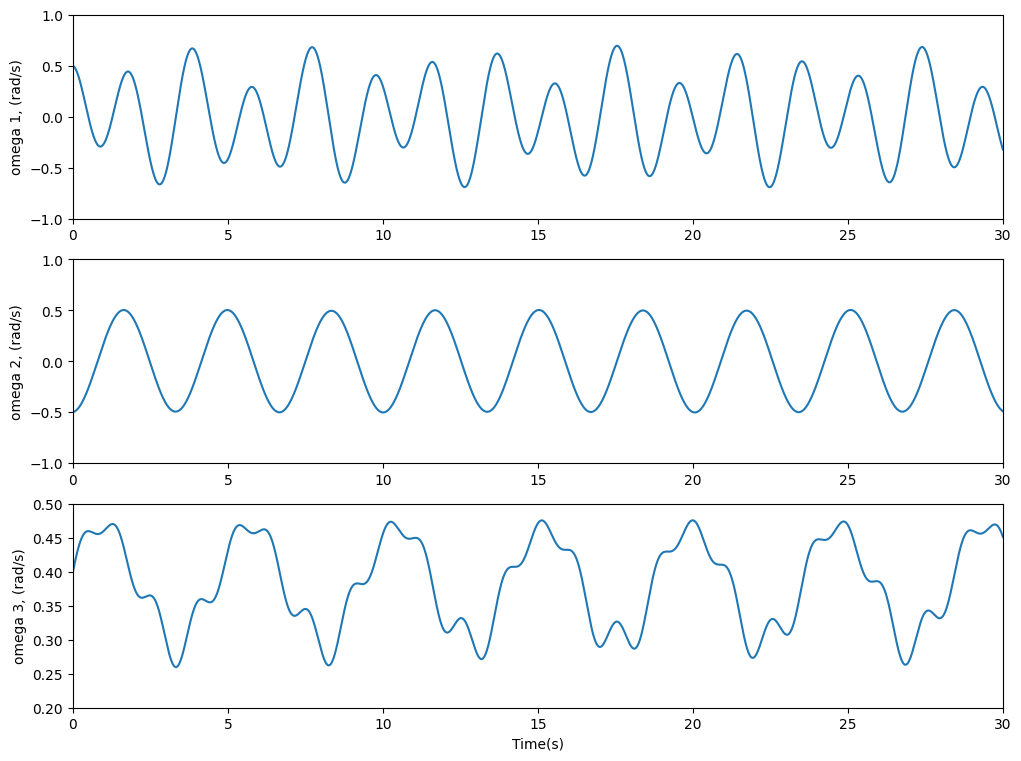

In [58]:
t_list = np.linspace(t_span[0], t_span[1], k_max)

fig, axs = plt.subplots(3,1,figsize=(12,9))

axs[0].plot(t_list, omega1)
axs[0].set_ylim(-1, 1)
axs[0].set_xlim(0,30)
axs[0].set_ylabel( 'omega 1, (rad/s)')

axs[1].plot(t_list, omega2)
axs[1].set_ylim(-1, 1)
axs[1].set_xlim(0,30)
axs[1].set_ylabel( 'omega 2, (rad/s)')

axs[2].plot(t_list, omega3)
axs[2].set_ylim(0.2, 0.5)
axs[2].set_xlabel('Time(s)')
axs[2].set_xlim(0,30)
axs[2].set_ylabel( 'omega 3, (rad/s)')


plt.show()